## LLM agents workshop, database agents and semantic search ##
---NOT YET UPDATED---

Quering existing database wether regular SQL ones, or more complex knowledge graphs and vector databases based on user request is one of the major use-cases of the agents.
Today we will talk how to do it with just-agents library

##  Quering SQL-lite database with ageing research questions

We will start from quering well known Open-Genes database
For this tutorial, we'll be interacting with the [Open-Genes database](https://open-genes.com/genes) which is devoted to longevity related genes.
We'll be using a simplified version stored in an SQLite file. You can access the original database file at:

[https://github.com/longevity-genie/longevity_gpts/blob/main/open_genes/data/open_genes.sqlite](https://github.com/longevity-genie/longevity_gpts/blob/main/open_genes/data/open_genes.sqlite)

Let's download the database first

In [1]:
!wget https://github.com/longevity-genie/longevity_gpts/raw/main/open_genes/data/open_genes.sqlite -O open_genes.sqlite

--2025-04-30 19:07:46--  https://github.com/longevity-genie/longevity_gpts/raw/main/open_genes/data/open_genes.sqlite
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/longevity-genie/longevity_gpts/main/open_genes/data/open_genes.sqlite [following]
--2025-04-30 19:07:46--  https://raw.githubusercontent.com/longevity-genie/longevity_gpts/main/open_genes/data/open_genes.sqlite
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1150976 (1.1M) [application/octet-stream]
Saving to: ‘open_genes.sqlite’

open_genes.sqlite   100%[===================>]   1.10M  --.-KB/s    in 0.03s   

2025-04-30 19:07:46 (3

We need to give our agents the tools which he will execute to interact with the database.

The most important is to let the agent query the database. Just-Agents library parses the the functin syntax and its comment to let LLM know how to use it. The comment is very important

In [2]:
import sqlite3

def sqlite_query(database: str, sql: str) -> str:
    """ This function allows executing query the SQL database. It returns query results as text. The unput must be SQL query to execute"""
    conn = sqlite3.connect(database)
    cursor = conn.cursor()

    cursor.execute(sql)
    try:
        rows = cursor.fetchall()
        if rows is None or len(rows) == 0:
            conn.close()
            return ""
        names = [description[0] for description in cursor.description]
        text = "; ".join(names) + "\n"
        for row in rows:
            row = [str(i) for i in row]
            text += "; ".join(row) + "\n"
    finally:
        conn.close()

    return text

Let's first check that functions work on its own, without agent

In [3]:
tables = sqlite_query("open_genes.sqlite","SELECT name FROM sqlite_master WHERE type='table';")
print("Tables:", tables)

Tables: name
lifespan_change
gene_criteria
gene_hallmarks
longevity_associations




To query the dataase and agent should also know its structure. To let it know the structure we prepared a SQL function to let it use it

In [4]:
import sqlite3

def extract_db_structure(db_path):
    """
    Connects to the SQLite database at default database and extracts the structure
    (table names and column definitions) of all tables in the database.

    Parameters:
        db_path (str or Path): The path to the SQLite database file.

    Returns:
        dict: A dictionary where keys are table names and values are lists of
              dictionaries containing column information.
    """
    # Connect to the SQLite database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Query to get all table names in the database
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()

    # Loop through the tables and get their schema
    db_structure = {}
    for table in tables:
        table_name = table[0]  # Extract the table name from the tuple
        # Get the table schema using PRAGMA table_info
        cursor.execute(f"PRAGMA table_info('{table_name}');")
        columns = cursor.fetchall()
        # Each column is a tuple: (cid, name, type, notnull, dflt_value, pk)
        column_info = []
        for column in columns:
            col_dict = {
                'cid': column[0],
                'name': column[1],
                'type': column[2],
                'notnull': bool(column[3]),
                'dflt_value': column[4],
                'pk': bool(column[5])
            }
            column_info.append(col_dict)
        db_structure[table_name] = column_info

    # Close the connection
    conn.close()

    return db_structure

Let's test the query by outputing the tables, in a human readable format

In [5]:
def print_db_structure(db_structure):
    """
    Prints the database structure in a readable format.

    Parameters:
        db_structure (dict): The database structure as returned by extract_db_structure.
    """
    for table_name, columns in db_structure.items():
        print(f"Table: {table_name}")
        print("Columns:")
        for col in columns:
            pk = 'PRIMARY KEY' if col['pk'] else ''
            notnull = 'NOT NULL' if col['notnull'] else ''
            default = f"DEFAULT {col['dflt_value']}" if col['dflt_value'] else ''
            constraints = ' '.join(filter(None, [pk, notnull, default]))
            print(f"  - {col['name']} ({col['type']}) {constraints}")
        print("\n")  # Add an empty line after each table for readability
print_db_structure(extract_db_structure("open_genes.sqlite"))

Table: lifespan_change
Columns:
  - HGNC (TEXT) 
  - model_organism (TEXT) 
  - sex (TEXT) 
  - line (TEXT) 
  - effect_on_lifespan (TEXT) 
  - control_cohort_size (REAL) 
  - experiment_cohort_size (REAL) 
  - quantity_of_animals_in_cage_or_container (REAL) 
  - containment_t_celsius_from (REAL) 
  - containment_t_celsius_to (TEXT) 
  - diet (TEXT) 
  - target_gene_expression_change (REAL) 
  - control_lifespan_min (REAL) 
  - control_lifespan_mean (REAL) 
  - control_lifespan_median (REAL) 
  - control_lifespan_max (REAL) 
  - experiment_lifespan_min (REAL) 
  - experiment_lifespan_mean (REAL) 
  - experiment_lifespan_median (REAL) 
  - experiment_lifespan_max (REAL) 
  - lifespan_time_unit (TEXT) 
  - lifespan_percent_change_min (REAL) 
  - significance_min (INTEGER) 
  - lifespan_percent_change_mean (REAL) 
  - significance_mean (INTEGER) 
  - lifespan_percent_change_median (REAL) 
  - significance_median (INTEGER) 
  - lifespan_percent_change_max (REAL) 
  - significance_max (INTE

First, let's install the just-agent library with pip and set up API keys for Groq. Note- API keys for GROQ are stored as a secret in the notebook so you just have to load them

In [6]:
!pip install just-agents-core==0.7.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 57.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.5 MB/s eta 0:00:00
  Created wheel for litellm: filename=litellm-1.67.4.post1-py3-none-any.whl size=7635269 sha256=7d4179654071b15c3b243d175240374c36d826505ddd06601cc1858d9f79f5f1
  Stored in directory: /root/.cache/pip/wheels/18/f5/b1/312d8b379ff740d2fe9bda74ac2fe87ae4f600ce9af3a44fb7
Successfully built litellm
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: rich
    Found existing installation: rich 13.9.4
    Uninstalling rich-13.9.4:
      Successfully uninstalled rich-13.9.4
ERROR: pip's dependency resolv

In [7]:
import os
import getpass
from dotenv import load_dotenv

def get_api_keys():
  """Gets API keys from the user."""
  load_dotenv(override=True)

  # Check if GROQ_API_KEY is already set in environment
  groq_api_key = os.environ.get("GROQ_API_KEY")
  openai_api_key = os.environ.get("OPENAI_API_KEY")

  # Only prompt for key if not already set
  if not groq_api_key:
    print("Please enter your API keys:")
    groq_api_key = getpass.getpass("GROQ_API_KEY: ")
    # Set environment variable
    os.environ["GROQ_API_KEY"] = groq_api_key
    print("GROQ_API key set successfully.")
  else:
    print("GROQ API key already set in environment.")

  if not openai_api_key:
      print("Please enter your API keys:")
      openai_api_key = getpass.getpass("OPENAI_API_KEY: ")
      # Set environment variable
      os.environ["OPENAI_API_KEY"] = openai_api_key
      print("OPENAI_API key set successfully.")
  else:
    print("OPENAI API key already set in environment.")

# Call the function to get API keys from the user
get_api_keys()

Please enter your API keys:
GROQ_API_KEY: ··········
GROQ_API key set successfully.
Please enter your API keys:
OPENAI_API_KEY: ··········
OPENAI_API key set successfully.


The following code just allows for user to see all comands and text outputed in the interface- it is needed to see all that comes out if the output is large.

In [8]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Then we will create a custom simple agent class that will be able to query a database and extract it's structure.

In [9]:
import asyncio
import json
import just_agents
from just_agents import llm_options
from just_agents.base_agent import BaseAgent, ChatAgent

options=llm_options.OPENAI_GPT4oMINI

db_agent = ChatAgent(role = "helpful agent which knows how operate with databases",
          goal= "help users by using SQL syntax to form comands to work with database",
          task = "formulate appropriate comands to operate in given database.Known database is open_genes.sqlite",
          llm_options = options,
          tools = [sqlite_query, extract_db_structure]
                     )

And now to give it something to search

In [10]:
prompt = "Interventions on which genes extended mice lifespan most of all? Search all the relevant tables in the open-genes sqlite and only for mouse"

In [11]:
db_agent.query(prompt)
print(db_agent.memory.pretty_print_all_messages())

'Here are the genes that have been associated with the most significant lifespan extension in mice, along with the maximum percentage change in lifespan and the interventions that improved lifespan:\n\n1. **PROP1**\n   - **Lifespan Percent Change Max**: 60.0%\n   - **Intervention**: insulin sensitivity, INS/IGFR pathway\n\n2. **PROP1**\n   - **Lifespan Percent Change Max**: 46.0%\n   - **Intervention**: None\n\n3. **PIK3CA**\n   - **Lifespan Percent Change Max**: 45.0%\n   - **Intervention**: None\n\n4. **PROP1**\n   - **Lifespan Percent Change Max**: 44.7%\n   - **Intervention**: glucose metabolism, INS/IGFR pathway\n\n5. **PROP1**\n   - **Lifespan Percent Change Max**: 44.0%\n   - **Intervention**: None\n\n6. **BUB1B**\n   - **Lifespan Percent Change Max**: 40.5%\n   - **Intervention**: None\n\n7. **TERT**\n   - **Lifespan Percent Change Max**: 40.4%\n   - **Intervention**: glucose metabolism, mitochondrial function, building and protection of telomeres, body composition, hair/coat, 

╭─────────────────────────────────────────────────── [System] ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ helpful agent which knows how operate with databases                                                            │
│ help users by using SQL syntax to form comands to work with database                                            │
│ formulate appropriate comands to operate in given database.Known database is open_genes.sqlite                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── [User] ─────────────────────────────────────────────────────╮
│ Interventions on which genes extended mice lifespan most of all? Search all the relevant tables in the          │
│ open-genes sqlite and only for mouse                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── [Assistant] ──────────────────────────────────────────────────╮
│ Tool Call to extract_db_structure:                                                                              │
│ {"db_path":"open_genes.sqlite"}                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── [Tool] ─────────────────────────────────────────────────────╮
│ Response from extract_db_structure:                                                                             │
│ {'lifespan_change': [{'cid': 0, 'name': 'HGNC', 'type': 'TEXT', 'notnull': False, 'dflt_value': None, 'pk':     │
│ False}, {'cid': 1, 'name': 'model_organism', 'type': 'TEXT', 'notnull': False, 'dflt_value': None, 'pk':        │
│ False}, {'cid': 2, 'name': 'sex', 'type': 'TEXT', 'notnull': False, 'dflt_value': None, 'pk': False}, {'cid':   │
│ 3, 'name': 'line', 'type': 'TEXT', 'notnull': False, 'dflt_value': None, 'pk': False}, {'cid': 4, 'name':       │
│ 'effect_on_lifespan', 'type': 'TEXT', 'notnull': False, 'dflt_value': None, 'pk': False}, {'cid': 5, 'name':    │
│ 'control_cohort_size', 'type': 'REAL', 'notnull': False, 'dflt_value': None, 'pk': False}, {'cid': 6, 'name':   │
│ 'experiment_cohort_size', 'type': 'REAL', 'notnull': False, 'dflt_value': None, 'pk': False}, {'cid': 7,        │
│ 'name': 'quantity_of_animals_in_cage_or_container', 'type': 'REAL', 'notnull': False, 'dflt_value': None, 'pk': │
│ False}, {'cid': 8, 'name': 'containment_t_celsius_from', 'type': 'REAL', 'notnull': False, 'dflt_value': None,  │
│ 'pk': False}, {'cid': 9, 'name': 'containment_t_celsius_to', 'type': 'TEXT', 'notnull': False, 'dflt_value':    │
│ None, 'pk': False}, {'cid': 10, 'name': 'diet', 'type': 'TEXT', 'notnull': False, 'dflt_value': None, 'pk':     │
│ False}, {'cid': 11, 'name': 'target_gene_expression_change', 'type': 'REAL', 'notnull': False, 'dflt_value':    │
│ None, 'pk': False}, {'cid': 12, 'name': 'control_lifespan_min', 'type': 'REAL', 'notnull': False, 'dflt_value': │
│ None, 'pk': False}, {'cid': 13, 'name': 'control_lifespan_mean', 'type': 'REAL', 'notnull': False,              │
│ 'dflt_value': None, 'pk': False}, {'cid': 14, 'name': 'control_lifespan_median', 'type': 'REAL', 'notnull':     │
│ False, 'dflt_value': None, 'pk': False}, {'cid': 15, 'name': 'control_lifespan_max', 'type': 'REAL', 'notnull': │
│ False, 'dflt_value': None, 'pk': False}, {'cid': 16, 'name': 'experiment_lifespan_min', 'type': 'REAL',         │
│ 'notnull': False, 'dflt_value': None, 'pk': False}, {'cid': 17, 'name': 'experiment_lifespan_mean', 'type':     │
│ 'REAL', 'notnull': False, 'dflt_value': None, 'pk': False}, {'cid': 18, 'name': 'experiment_lifespan_median',   │
│ 'type': 'REAL', 'notnull': False, 'dflt_value': None, 'pk': False}, {'cid': 19, 'name':                         │
│ 'experiment_lifespan_max', 'type': 'REAL', 'notnull': False, 'dflt_value': None, 'pk': False}, {'cid': 20,      │
│ 'name': 'lifespan_time_unit', 'type': 'TEXT', 'notnull': False, 'dflt_value': None, 'pk': False}, {'cid': 21,   │
│ 'name': 'lifespan_percent_change_min', 'type': 'REAL', 'notnull': False, 'dflt_value': None, 'pk': False},      │
│ {'cid': 22, 'name': 'significance_min', 'type': 'INTEGER', 'notnull': False, 'dflt_value': None, 'pk': False},  │
│ {'cid': 23, 'name': 'lifespan_percent_change_mean', 'type': 'REAL', 'notnull': False, 'dflt_value': None, 'pk': │
│ False}, {'cid': 24, 'name': 'significance_mean', 'type': 'INTEGER', 'notnull': False, 'dflt_value': None, 'pk': │
│ False}, {'cid': 25, 'name': 'lifespan_percent_change_median', 'type': 'REAL', 'notnull': False, 'dflt_value':   │
│ None, 'pk': False}, {'cid': 26, 'name': 'significance_median', 'type': 'INTEGER', 'notnull': False,             │
│ 'dflt_value': None, 'pk': False}, {'cid': 27, 'name': 'lifespan_percent_change_max', 'type': 'REAL', 'notnull': │
│ False, 'dflt_value': None, 'pk': False}, {'cid': 28, 'name': 'significance_max', 'type': 'INTEGER', 'notnull':  │
│ False, 'dflt_value': None, 'pk': False}, {'cid': 29, 'name': 'intervention_deteriorates', 'type': 'TEXT',       │
│ 'notnull': False, 'dflt_value': None, 'pk': False}, {'cid': 30, 'name': 'intervention_improves', 'type':        │
│ 'TEXT', 'notnull': False, 'dflt_value': None, 'pk': Fa

╭────────────────────────────────────────────────── [Assistant] ──────────────────────────────────────────────────╮
│ Tool Call to sqlite_query:                                                                                      │
│ {"database":"open_genes.sqlite","sql":"SELECT HGNC, lifespan_percent_change_max, intervention_improves FROM     │
│ lifespan_change WHERE model_organism = 'mouse' ORDER BY lifespan_percent_change_max DESC;"}                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── [Tool] ─────────────────────────────────────────────────────╮
│ Response from sqlite_query:                                                                                     │
│ HGNC; lifespan_percent_change_max; intervention_improves                                                        │
│ PROP1; 60.0; insulin sensitivity,INS/IGFR pathway                                                               │
│ PROP1; 46.0; None                                                                                               │
│ PIK3CA; 45.0; None                                                                                              │
│ PROP1; 44.7; glucose metabolism,INS/IGFR pathway                                                                │
│ PROP1; 44.0; None                                                                                               │
│ BUB1B; 40.5; None                                                                                               │
│ TERT; 40.4; glucose metabolism,mitochondrial function,building and protection of telomeres,body                 │
│ composition,hair/coat,locomotor function                                                                        │
│ POU1F1; 40.0; None                                                                                              │
│ POU1F1; 39.4; immune function,intercellular matrix                                                              │
│ PROP1; 39.0; insulin sensitivity,INS/IGFR pathway                                                               │
│ GHRHR; 38.0; None                                                                                               │
│ PAPPA; 38.0; carcinogenesis,INS/IGFR pathway,cardiovascular system,endocrine system,nervous system,reproductive │
│ function,renal function                                                                                         │
│ CDKN2A; 36.4; cardiovascular system,senescence,body composition,carcinogenesis,renal function                   │
│ GHR; 35.8; None                                                                                                 │
│ POU1F1; 33.8; None                                                                                              │
│ GHRH; 33.0; glucose metabolism,stress responce,INS/IGFR pathway                                                 │
│ VEGFA; 33.0; cardiovascular system,oxidation/antioxidant function,senescence,inflammation,skin,bone,body        │
│ composition,carcinogenesis,angiogenesis,liver                                                                   │
│ GHR; 31.6; insulin sensitivity,glucose metabolism,INS/IGFR pathway                                              │
│ GHRH; 31.0; glucose metabolism,stress responce,INS/IGFR pathway                                                 │
│ VEGFA; 30.0; cardiovascular system,oxidation/antioxidant function,senescence,inflammation,skin,bone,body        │
│ composition,carcinogenesis,angiogenesis,liver                                                                   │
│ COQ7; 29.9; oxidation/antioxidant function,DNA metabolism                                                       │
│ FST; 29.8; glucose metabolism,mitochondrial function,body composition,hair/coat,locomotor function              │
│ MT1E; 28.8; cardiovascular system,oxidation/antioxidant function                                                │
│ CISD2; 28.7; mitochondrial function,DNA metabolism,metabolism,nervous system,skin,muscle,hair/coat              │
│ NLRP3; 27.9; cardiovascular system,building and protection of telomeres,glucose metabolism,metabolism,autophagy │
│ PML; 27.6; oxidation/antioxidant function,senescence,apoptosis,stress responce                                  │
│ GHRH; 26.8; None                                                                                                │
│ PPARG; 26.0; insulin sensitivity,lipid metabolism,body

╭────────────────────────────────────────────────── [Assistant] ──────────────────────────────────────────────────╮
│ Here are the genes that have been associated with the most significant lifespan extension in mice, along with   │
│ the maximum percentage change in lifespan and the interventions that improved lifespan:                         │
│                                                                                                                 │
│ 1. **PROP1**                                                                                                    │
│    - **Lifespan Percent Change Max**: 60.0%                                                                     │
│    - **Intervention**: insulin sensitivity, INS/IGFR pathway                                                    │
│                                                                                                                 │
│ 2. **PROP1**                                                                                                    │
│    - **Lifespan Percent Change Max**: 46.0%                                                                     │
│    - **Intervention**: None                                                                                     │
│                                                                                                                 │
│ 3. **PIK3CA**                                                                                                   │
│    - **Lifespan Percent Change Max**: 45.0%                                                                     │
│    - **Intervention**: None                                                                                     │
│                                                                                                                 │
│ 4. **PROP1**                                                                                                    │
│    - **Lifespan Percent Change Max**: 44.7%                                                                     │
│    - **Intervention**: glucose metabolism, INS/IGFR pathway                                                     │
│                                                                                                                 │
│ 5. **PROP1**                                                                                                    │
│    - **Lifespan Percent Change Max**: 44.0%                                                                     │
│    - **Intervention**: None                                                                                     │
│                                                                                                                 │
│ 6. **BUB1B**                                                                                                    │
│    - **Lifespan Percent Change Max**: 40.5%                                                                     │
│    - **Intervention**: None                                                                                     │
│                                                                                                                 │
│ 7. **TERT**                                                                                                     │
│    - **Lifespan Percent Change Max**: 40.4%                                                                     │
│    - **Intervention**: glucose metabolism, mitochondrial function, building and protection of telomeres, body   │
│ composition, hair/coat, locomotor function                                                                      │
│                                                                                                                 │
│ 8. **POU1F1**                                                                                                   │
│    - **Lifespan Percent Change Max**: 40.0%           

None


What if we changed the prompt? And let's run it.

In [12]:
prompt = "Are there any liver-specific interventions that increase lifespan in mice? Search all the relevant tables in the open-genes sqlite and only for mouse"

In [13]:
db_agent.query(prompt)
print(db_agent.memory.pretty_print_all_messages())

'Here are the liver-specific interventions that have been associated with increased lifespan in mice, along with the maximum percentage change in lifespan:\n\n1. **VEGFA**\n   - **Lifespan Percent Change Max**: 33.0%\n   - **Intervention**: cardiovascular system, oxidation/antioxidant function, senescence, inflammation, skin, bone, body composition, carcinogenesis, angiogenesis, liver\n\n2. **VEGFA**\n   - **Lifespan Percent Change Max**: 30.0%\n   - **Intervention**: cardiovascular system, oxidation/antioxidant function, senescence, inflammation, skin, bone, body composition, carcinogenesis, angiogenesis, liver\n\n3. **CEBPB**\n   - **Lifespan Percent Change Max**: 13.6%\n   - **Intervention**: glucose metabolism, immune function, body composition, carcinogenesis, liver, blood, locomotor function\n\n4. **MTBP**\n   - **Lifespan Percent Change Max**: 12.7%\n   - **Intervention**: metabolism, carcinogenesis, liver\n\n5. **PRKAR2B**\n   - **Lifespan Percent Change Max**: 10.4%\n   - **In

╭─────────────────────────────────────────────────── [System] ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ helpful agent which knows how operate with databases                                                            │
│ help users by using SQL syntax to form comands to work with database                                            │
│ formulate appropriate comands to operate in given database.Known database is open_genes.sqlite                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── [User] ─────────────────────────────────────────────────────╮
│ Interventions on which genes extended mice lifespan most of all? Search all the relevant tables in the          │
│ open-genes sqlite and only for mouse                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── [Assistant] ──────────────────────────────────────────────────╮
│ Tool Call to extract_db_structure:                                                                              │
│ {"db_path":"open_genes.sqlite"}                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── [Tool] ─────────────────────────────────────────────────────╮
│ Response from extract_db_structure:                                                                             │
│ {'lifespan_change': [{'cid': 0, 'name': 'HGNC', 'type': 'TEXT', 'notnull': False, 'dflt_value': None, 'pk':     │
│ False}, {'cid': 1, 'name': 'model_organism', 'type': 'TEXT', 'notnull': False, 'dflt_value': None, 'pk':        │
│ False}, {'cid': 2, 'name': 'sex', 'type': 'TEXT', 'notnull': False, 'dflt_value': None, 'pk': False}, {'cid':   │
│ 3, 'name': 'line', 'type': 'TEXT', 'notnull': False, 'dflt_value': None, 'pk': False}, {'cid': 4, 'name':       │
│ 'effect_on_lifespan', 'type': 'TEXT', 'notnull': False, 'dflt_value': None, 'pk': False}, {'cid': 5, 'name':    │
│ 'control_cohort_size', 'type': 'REAL', 'notnull': False, 'dflt_value': None, 'pk': False}, {'cid': 6, 'name':   │
│ 'experiment_cohort_size', 'type': 'REAL', 'notnull': False, 'dflt_value': None, 'pk': False}, {'cid': 7,        │
│ 'name': 'quantity_of_animals_in_cage_or_container', 'type': 'REAL', 'notnull': False, 'dflt_value': None, 'pk': │
│ False}, {'cid': 8, 'name': 'containment_t_celsius_from', 'type': 'REAL', 'notnull': False, 'dflt_value': None,  │
│ 'pk': False}, {'cid': 9, 'name': 'containment_t_celsius_to', 'type': 'TEXT', 'notnull': False, 'dflt_value':    │
│ None, 'pk': False}, {'cid': 10, 'name': 'diet', 'type': 'TEXT', 'notnull': False, 'dflt_value': None, 'pk':     │
│ False}, {'cid': 11, 'name': 'target_gene_expression_change', 'type': 'REAL', 'notnull': False, 'dflt_value':    │
│ None, 'pk': False}, {'cid': 12, 'name': 'control_lifespan_min', 'type': 'REAL', 'notnull': False, 'dflt_value': │
│ None, 'pk': False}, {'cid': 13, 'name': 'control_lifespan_mean', 'type': 'REAL', 'notnull': False,              │
│ 'dflt_value': None, 'pk': False}, {'cid': 14, 'name': 'control_lifespan_median', 'type': 'REAL', 'notnull':     │
│ False, 'dflt_value': None, 'pk': False}, {'cid': 15, 'name': 'control_lifespan_max', 'type': 'REAL', 'notnull': │
│ False, 'dflt_value': None, 'pk': False}, {'cid': 16, 'name': 'experiment_lifespan_min', 'type': 'REAL',         │
│ 'notnull': False, 'dflt_value': None, 'pk': False}, {'cid': 17, 'name': 'experiment_lifespan_mean', 'type':     │
│ 'REAL', 'notnull': False, 'dflt_value': None, 'pk': False}, {'cid': 18, 'name': 'experiment_lifespan_median',   │
│ 'type': 'REAL', 'notnull': False, 'dflt_value': None, 'pk': False}, {'cid': 19, 'name':                         │
│ 'experiment_lifespan_max', 'type': 'REAL', 'notnull': False, 'dflt_value': None, 'pk': False}, {'cid': 20,      │
│ 'name': 'lifespan_time_unit', 'type': 'TEXT', 'notnull': False, 'dflt_value': None, 'pk': False}, {'cid': 21,   │
│ 'name': 'lifespan_percent_change_min', 'type': 'REAL', 'notnull': False, 'dflt_value': None, 'pk': False},      │
│ {'cid': 22, 'name': 'significance_min', 'type': 'INTEGER', 'notnull': False, 'dflt_value': None, 'pk': False},  │
│ {'cid': 23, 'name': 'lifespan_percent_change_mean', 'type': 'REAL', 'notnull': False, 'dflt_value': None, 'pk': │
│ False}, {'cid': 24, 'name': 'significance_mean', 'type': 'INTEGER', 'notnull': False, 'dflt_value': None, 'pk': │
│ False}, {'cid': 25, 'name': 'lifespan_percent_change_median', 'type': 'REAL', 'notnull': False, 'dflt_value':   │
│ None, 'pk': False}, {'cid': 26, 'name': 'significance_median', 'type': 'INTEGER', 'notnull': False,             │
│ 'dflt_value': None, 'pk': False}, {'cid': 27, 'name': 'lifespan_percent_change_max', 'type': 'REAL', 'notnull': │
│ False, 'dflt_value': None, 'pk': False}, {'cid': 28, 'name': 'significance_max', 'type': 'INTEGER', 'notnull':  │
│ False, 'dflt_value': None, 'pk': False}, {'cid': 29, 'name': 'intervention_deteriorates', 'type': 'TEXT',       │
│ 'notnull': False, 'dflt_value': None, 'pk': False}, {'cid': 30, 'name': 'intervention_improves', 'type':        │
│ 'TEXT', 'notnull': False, 'dflt_value': None, 'pk': Fa

╭────────────────────────────────────────────────── [Assistant] ──────────────────────────────────────────────────╮
│ Tool Call to sqlite_query:                                                                                      │
│ {"database":"open_genes.sqlite","sql":"SELECT HGNC, lifespan_percent_change_max, intervention_improves FROM     │
│ lifespan_change WHERE model_organism = 'mouse' ORDER BY lifespan_percent_change_max DESC;"}                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── [Tool] ─────────────────────────────────────────────────────╮
│ Response from sqlite_query:                                                                                     │
│ HGNC; lifespan_percent_change_max; intervention_improves                                                        │
│ PROP1; 60.0; insulin sensitivity,INS/IGFR pathway                                                               │
│ PROP1; 46.0; None                                                                                               │
│ PIK3CA; 45.0; None                                                                                              │
│ PROP1; 44.7; glucose metabolism,INS/IGFR pathway                                                                │
│ PROP1; 44.0; None                                                                                               │
│ BUB1B; 40.5; None                                                                                               │
│ TERT; 40.4; glucose metabolism,mitochondrial function,building and protection of telomeres,body                 │
│ composition,hair/coat,locomotor function                                                                        │
│ POU1F1; 40.0; None                                                                                              │
│ POU1F1; 39.4; immune function,intercellular matrix                                                              │
│ PROP1; 39.0; insulin sensitivity,INS/IGFR pathway                                                               │
│ GHRHR; 38.0; None                                                                                               │
│ PAPPA; 38.0; carcinogenesis,INS/IGFR pathway,cardiovascular system,endocrine system,nervous system,reproductive │
│ function,renal function                                                                                         │
│ CDKN2A; 36.4; cardiovascular system,senescence,body composition,carcinogenesis,renal function                   │
│ GHR; 35.8; None                                                                                                 │
│ POU1F1; 33.8; None                                                                                              │
│ GHRH; 33.0; glucose metabolism,stress responce,INS/IGFR pathway                                                 │
│ VEGFA; 33.0; cardiovascular system,oxidation/antioxidant function,senescence,inflammation,skin,bone,body        │
│ composition,carcinogenesis,angiogenesis,liver                                                                   │
│ GHR; 31.6; insulin sensitivity,glucose metabolism,INS/IGFR pathway                                              │
│ GHRH; 31.0; glucose metabolism,stress responce,INS/IGFR pathway                                                 │
│ VEGFA; 30.0; cardiovascular system,oxidation/antioxidant function,senescence,inflammation,skin,bone,body        │
│ composition,carcinogenesis,angiogenesis,liver                                                                   │
│ COQ7; 29.9; oxidation/antioxidant function,DNA metabolism                                                       │
│ FST; 29.8; glucose metabolism,mitochondrial function,body composition,hair/coat,locomotor function              │
│ MT1E; 28.8; cardiovascular system,oxidation/antioxidant function                                                │
│ CISD2; 28.7; mitochondrial function,DNA metabolism,metabolism,nervous system,skin,muscle,hair/coat              │
│ NLRP3; 27.9; cardiovascular system,building and protection of telomeres,glucose metabolism,metabolism,autophagy │
│ PML; 27.6; oxidation/antioxidant function,senescence,apoptosis,stress responce                                  │
│ GHRH; 26.8; None                                                                                                │
│ PPARG; 26.0; insulin sensitivity,lipid metabolism,body

╭────────────────────────────────────────────────── [Assistant] ──────────────────────────────────────────────────╮
│ Here are the genes that have been associated with the most significant lifespan extension in mice, along with   │
│ the maximum percentage change in lifespan and the interventions that improved lifespan:                         │
│                                                                                                                 │
│ 1. **PROP1**                                                                                                    │
│    - **Lifespan Percent Change Max**: 60.0%                                                                     │
│    - **Intervention**: insulin sensitivity, INS/IGFR pathway                                                    │
│                                                                                                                 │
│ 2. **PROP1**                                                                                                    │
│    - **Lifespan Percent Change Max**: 46.0%                                                                     │
│    - **Intervention**: None                                                                                     │
│                                                                                                                 │
│ 3. **PIK3CA**                                                                                                   │
│    - **Lifespan Percent Change Max**: 45.0%                                                                     │
│    - **Intervention**: None                                                                                     │
│                                                                                                                 │
│ 4. **PROP1**                                                                                                    │
│    - **Lifespan Percent Change Max**: 44.7%                                                                     │
│    - **Intervention**: glucose metabolism, INS/IGFR pathway                                                     │
│                                                                                                                 │
│ 5. **PROP1**                                                                                                    │
│    - **Lifespan Percent Change Max**: 44.0%                                                                     │
│    - **Intervention**: None                                                                                     │
│                                                                                                                 │
│ 6. **BUB1B**                                                                                                    │
│    - **Lifespan Percent Change Max**: 40.5%                                                                     │
│    - **Intervention**: None                                                                                     │
│                                                                                                                 │
│ 7. **TERT**                                                                                                     │
│    - **Lifespan Percent Change Max**: 40.4%                                                                     │
│    - **Intervention**: glucose metabolism, mitochondrial function, building and protection of telomeres, body   │
│ composition, hair/coat, locomotor function                                                                      │
│                                                                                                                 │
│ 8. **POU1F1**                                                                                                   │
│    - **Lifespan Percent Change Max**: 40.0%           

╭──────────────────────────────────────────────────── [User] ─────────────────────────────────────────────────────╮
│ Are there any liver-specific interventions that increase lifespan in mice? Search all the relevant tables in    │
│ the open-genes sqlite and only for mouse                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── [Assistant] ──────────────────────────────────────────────────╮
│ Tool Call to sqlite_query:                                                                                      │
│ {"database":"open_genes.sqlite","sql":"SELECT HGNC, lifespan_percent_change_max, intervention_improves FROM     │
│ lifespan_change WHERE model_organism = 'mouse' AND intervention_improves LIKE '%liver%' ORDER BY                │
│ lifespan_percent_change_max DESC;"}                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── [Tool] ─────────────────────────────────────────────────────╮
│ Response from sqlite_query:                                                                                     │
│ HGNC; lifespan_percent_change_max; intervention_improves                                                        │
│ VEGFA; 33.0; cardiovascular system,oxidation/antioxidant function,senescence,inflammation,skin,bone,body        │
│ composition,carcinogenesis,angiogenesis,liver                                                                   │
│ VEGFA; 30.0; cardiovascular system,oxidation/antioxidant function,senescence,inflammation,skin,bone,body        │
│ composition,carcinogenesis,angiogenesis,liver                                                                   │
│ CEBPB; 13.6; glucose metabolism,immune function,body composition,carcinogenesis,liver,blood,locomotor function  │
│ MTBP; 12.7; metabolism,carcinogenesis,liver                                                                     │
│ PRKAR2B; 10.4; cardiovascular system,insulin sensitivity,body composition,carcinogenesis,renal                  │
│ function,liver,lipid metabolism                                                                                 │
│ MTBP; 7.5; metabolism,carcinogenesis,liver                                                                      │
│ MTBP; 4.5; metabolism,carcinogenesis,liver                                                                      │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── [Assistant] ──────────────────────────────────────────────────╮
│ Here are the liver-specific interventions that have been associated with increased lifespan in mice, along with │
│ the maximum percentage change in lifespan:                                                                      │
│                                                                                                                 │
│ 1. **VEGFA**                                                                                                    │
│    - **Lifespan Percent Change Max**: 33.0%                                                                     │
│    - **Intervention**: cardiovascular system, oxidation/antioxidant function, senescence, inflammation, skin,   │
│ bone, body composition, carcinogenesis, angiogenesis, liver                                                     │
│                                                                                                                 │
│ 2. **VEGFA**                                                                                                    │
│    - **Lifespan Percent Change Max**: 30.0%                                                                     │
│    - **Intervention**: cardiovascular system, oxidation/antioxidant function, senescence, inflammation, skin,   │
│ bone, body composition, carcinogenesis, angiogenesis, liver                                                     │
│                                                                                                                 │
│ 3. **CEBPB**                                                                                                    │
│    - **Lifespan Percent Change Max**: 13.6%                                                                     │
│    - **Intervention**: glucose metabolism, immune function, body composition, carcinogenesis, liver, blood,     │
│ locomotor function                                                                                              │
│                                                                                                                 │
│ 4. **MTBP**                                                                                                     │
│    - **Lifespan Percent Change Max**: 12.7%                                                                     │
│    - **Intervention**: metabolism, carcinogenesis, liver                                                        │
│                                                                                                                 │
│ 5. **PRKAR2B**                                                                                                  │
│    - **Lifespan Percent Change Max**: 10.4%                                                                     │
│    - **Intervention**: cardiovascular system, insulin sensitivity, body composition, carcinogenesis, renal      │
│ function, liver, lipid metabolism                                                                               │
│                                                                                                                 │
│ 6. **MTBP**                                                                                                     │
│    - **Lifespan Percent Change Max**: 7.5%                                                                      │
│    - **Intervention**: metabolism, carcinogenesis, liver                                                        │
│                                                                                                                 │
│ 7. **MTBP**                                                                                                     │
│    - **Lifespan Percent Change Max**: 4.5%                                                                      │
│    - **Intervention**: metabolism, carcinogenesis, liv

None



Here are some more questions to be tested

1. What genes need to be downregulated in worms to extend their lifespan?
2. What processes are improved in GHR knockout mice?
3. Which genetic intervention led to the greatest increase in lifespan in flies?
4. To what extent did the lifespan increase in mice overexpressing VEGFA?
5. Are there any liver-specific interventions that increase lifespan in mice?
6. Which gene-longevity association is confirmed by the greatest number of studies?
7. What polymorphisms in FOXO3 are associated with human longevity?
8. In which ethnic groups was the association of the APOE gene with longevity shown?
9. Is the INS gene polymorphism associated with longevity?
10. What genes are associated with transcriptional alterations?
11. Which hallmarks are associated with the KL gene?
12. What genes change their expression with aging in humans?
13. How many genes are associated with longevity in humans?
14. What types of studies have been conducted on the IGF1R gene?
15. What evidence of the link between PTEN and aging do you know?
16. What genes are associated with both longevity and altered expression in aged humans?
17. Is the expression of the ACE2 gene altered with aging in humans?
18. Interventions on which genes extended mice lifespan most of all?
19. Which knockdowns were most lifespan extending on model animals?

Then we will create a custom simple agent class that will be able to define the prompt according to user's input and will interact with other agents in an LLMsession.


The custom agent is based and inherits from [ChatAgent](https://github.com/longevity-genie/just-agents/blob/main/core/just_agents/base_agent.py) but it further exapands it with the custom system prompt formation and the calling part.

Calling_list is like the phone book of the agents- who knows if something is not working it should search for others that know how to solve it, while call_another is just so it knows faster than to start solving the prompt itself, it should **first** see who else can solve it.

In [14]:
from pydantic import Field
from typing import Optional,Any

class ExtraAgent(ChatAgent):

  #these attributes were added so that we can better define the prompt for each agent

    call_another: Optional[bool]= Field(default=True, description="Defines the agent's behaviour at first glance")
    calling_list: Optional[list[BaseAgent]]= Field(default=None, description="Defines the agent's connections")


    def model_post_init(self, __context: Any) -> None:
        # Call parent's post_init to maintain core functionality
        super().model_post_init(__context)


        if self.calling_list is None:
          self.call_another= False

The **forward** function allows to be used as a tool so that an agent can delate to another. Basically if calling_list tells ***who*** to call, forward function tells ***how*** to call it

In [15]:
choose_agent = ChatAgent(role = "helpful agent which knows how to search similar object and descriptions",
          goal= "help users by search closest item to their description",
          task = "formulate the name of other agents from the calling list",
          format="return the name of the agent to call only from the known list",
          llm_options = options)


In [16]:
def forward(agent: str,calling_list:list[BaseAgent], prompt:str):
  """
  Forwards the call from one agent to another, A to B, according to what A can't solve and B is trained in solving
  """

  return agent.query(prompt)

In [17]:
ponder_agent = ExtraAgent(role = "helpful agent which will only distribute the tasks to it's calling list and make minimal suggestions",
                         goal = "help users by guiding them to appropriate instances that will answer their questions",
                         task = "choose appropriate measures and agents to use to solve the questions.if there is no results let user know and ask for more info",
                         llm_options = options,
                         format="""all your answers you represent solely as JSON object without any text either beore or after it. The format is the following:
        {
        "user_question": "question",
        "answer": "your answer",
        "delegate_to": "agent_name",
        "question": "question_to_delegate",
        "final_answer": "final answer to the question"
        } If you do not delegate then call_another and question should be empty. if you are ready to answer the question then final_answer should be your answer, if not it must be empty""",
                         calling_list=[db_agent],
                          tools = [forward]
                         )

So let's give it a question that we tried in previous versions with a long prompt for the session itself.

And now let's run it.

In [18]:
ponder_agent.query(prompt)
print(ponder_agent.memory.pretty_print_all_messages())


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.



BadRequestError: litellm.BadRequestError: OpenAIException - Invalid schema for function 'forward': In context=('properties', 'calling_list'), array schema missing items.

## Semantic Similarity Search

When training large language models learned representation of the world, also known as embedding, where each token/word is represented as vector. By computing the distances between this vector we can compare similarity between their semantics. And we can use it in a search by using so-called vector-databases and using cosine distance between vectors as similarity measurement.

There specialized vector search engines like qdrant, weaviate, chroma, et. al.
Support of vector search is also getting into regular databases like MariaDB and search indexes like Elastic and Meili search.
Today we will use [Meili Search server](http://agingkills.eu:7700/) to show pros and cons of such search in comparison with conventional text-base search and we will also utilize hybrid search approach to get the both of the worlds

In [19]:
!pip install just-semantic-search-meili
!pip install just-semantic-search-scholar

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 27.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [20]:
from just_semantic_search.embeddings import load_gte_large

model = load_gte_large()

ImportError: cannot import name 'load_gte_large' from 'just_semantic_search.embeddings' (/usr/local/lib/python3.11/dist-packages/just_semantic_search/embeddings.py)

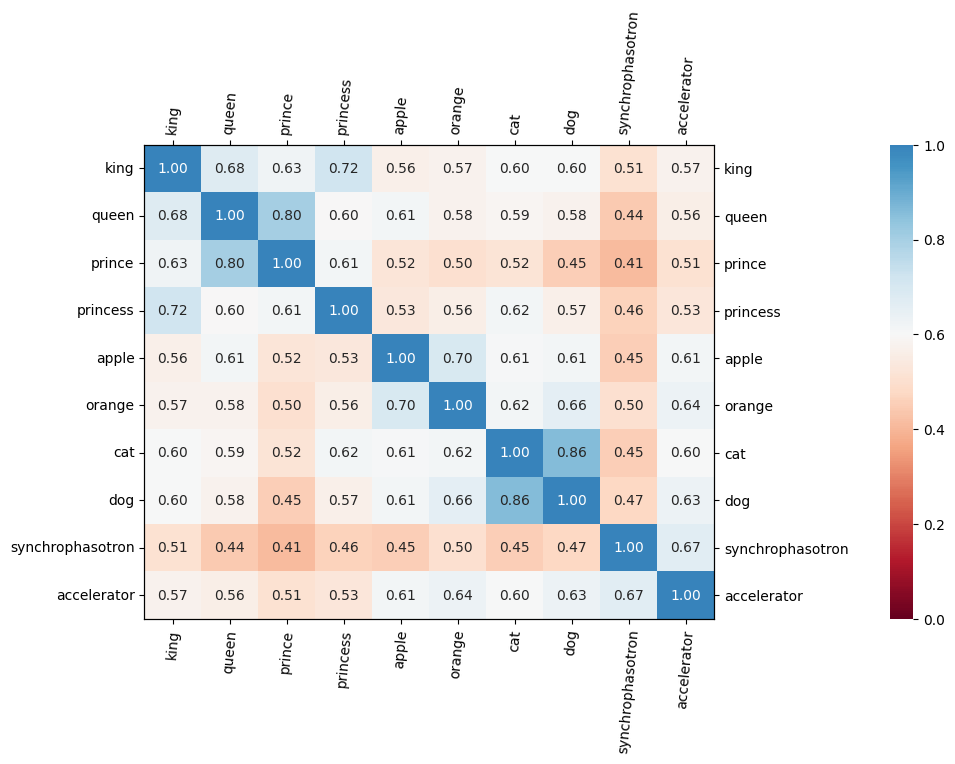

Saving to embedding_correlations.png


In [ ]:
from just_semantic_search.scholar.viz import visualize_embedding_correlations
visualize_embedding_correlations(["king", "queen", "prince", "princess", "apple", "orange", "cat", "dog", "synchrophasotron", "accelerator"], model=model)

Now let's see how numbers compare

In [ ]:
visualize_embedding_correlations(["3", "3.14", "3.1", "three", "thousand", "1000", "1000.314"], model=model)

NameError: name 'visualize_embedding_correlations' is not defined

## Testing some queries
with meili search.
So far we are using a toy deployment at [Meili Search at our server](http://agingkills.eu:7700/)

In [ ]:
import nest_asyncio
nest_asyncio.apply() #fixing collab specific issues with async

In [ ]:
from just_semantic_search.meili.rag import MeiliRAG, MeiliConfig
from just_semantic_search.embeddings import load_gte_large
from just_semantic_search.meili.rag import MeiliConfig
from just_semantic_search.text_splitters import SemanticSplitter

index_name = "tacutopapers"
model = load_gte_large()
splitter = SemanticSplitter(model=model, batch_size=64, normalize_embeddings=False)
host = "agingkills.eu"
port = 7700
api_key = "fancy_master_key"
config = MeiliConfig(host=host, port=port, api_key=api_key)
rag = MeiliRAG(index_name, splitter.model_name, config,
                    create_index_if_not_exists=True)

We are using a toy index with a subset of research papers of Robi Tacutu where we deliberately incorporated some extra content to see if the search would manage to solve it

In [ ]:
from rich.pretty import pprint

In [ ]:
content_question = rag.search("Gray wale lifespan", limit=5, semanticRatio=0.5)
pprint(content_question)

SearchResults[dict[str, Any]](
│   hits=[
│   │   {
│   │   │   'text': 'Gray whale transcriptome reveals longevity adaptations associated with DNA repair and ubiquitination. D Toren, A Kulaga, M Jethva, E Rubin, A V Snezhkina, A V Kudryavtseva, D Nowicki, R Tacutu, A A Moskalev, V E Fraifeld, 10.1111/acel.13158Aging Cell. 19PubMedToren, D.; Kulaga, A.; Jethva, M.; Rubin, E.; Snezhkina, A.V. ; Kudryavtseva, A.V. ; Nowicki, D.; Tacutu, R.; Moskalev, A.A.; Fraifeld, V.E. Gray whale transcriptome reveals longevity adaptations associated with DNA repair and ubiquitination. Aging Cell 2020, 19, e13158. [CrossRef] [PubMed]',
│   │   │   'source': '/home/antonkulaga/sources/just-semantic-search/data/tacutopapers_test_rsids_10k/10.txt',
│   │   │   'hash': '85c732c06a32624a4e727da71ffc57cc',
│   │   │   'metadata': {},
│   │   │   'token_count': None,
│   │   │   'fragment_num': None,
│   │   │   'total_fragments': None,
│   │   │   '_rankingScore': 0.26565656565656565,
│   │   │   '_rankingScoreDetails': {
│   │   │   │   'words': {'order': 0, 'matchingWords': 1, 'maxMatchingWords': 3, 'score': 0.3333333333333333},
│   │   │   │   'typo': {'order': 1, 'typoCount': 0, 'maxTypoCount': 1, 'score': 1.0},
│   │   │   │   'proximity': {'order': 2, 'score': 1.0},
│   │   │   │   'attribute': {
│   │   │   │   │   'order': 3,
│   │   │   │   │   'attributeRankingOrderScore': 0.6,
│   │   │   │   │   'queryWordDistanceScore': 1.0,
│   │   │   │   │   'score': 0.6
│   │   │   │   },
│   │   │   │   'exactness': {'order': 4, 'matchType': 'matchesStart', 'score': 0.6666666666666666}
│   │   │   }
│   │   },
│   │   {
│   │   │   'text': "Fig. 3 3Distribution of LAGs according to the number of phyla in which LAGs have orthologs. Each graph represents the distribution of LAGs (gray area) discovered in the indicated model species. The entire proteome was used as a control (dotted line). X-axis depicts the number of phyla in which the genes have orthologs. The medians of the distributions are presented as vertical lines: dotted line for all genes and smooth black line for LAGs. Longevity genes and interventions, H. Yanai et al.\n\nFig. S1 S1Percentage of Interactome LAG orthologs from the four model species.\n\nFig. S2 S2Percentage of LAG orthologs from the four model species after exclusion of proteins from enriched categories.\n\nFig. S3 S3GO Slim summary and enrichment analysis.\n\nFig. S4 S4Conservation index (CI) compared to concordancy of longevity effects.\n\nFig. S5 S5Method similarity score compared to concordancy of longevity effects.\n\nTable 1 ' 1Public' and 'private' enriched categories. The table depicts the most enriched categories for lists of proteins of all longevity-associated genes (all LAGs) and LAGs discovered by either lifespan extension (LSE-LAGs) or lifespan reduction (LSD-LAGs), under different evolutionary conservation criteria (defined as the presence of orthologs across a listed number of phyla). For a detailed enrichment analysis, seeTables S4-S6Public/Private Saccharomyces cerevisiae Caenorhabditis elegans Drosophila melanogaster Mus musculus\n\nPublic\n\nTaxa groups\n\nwhere orthologs\n\nare present\n\nat least 12 phyla\n\nat least 12 phyla\n\nat least 10 phyla\n\nat least 10 phyla\n\nAll LAGs\n\nRibosome and translation\n\nMitochondria\n\nCitrate cycle (TCA cycle)\n\nRibosome and translation\n\nMitochondria\n\nOxidative phosphorylation\n\nNADH activity\n\nFoxO signaling\n\nAutophagy\n\nDNA repair, especially\n\nNucleotide excision repair\n\nLSE\n\nLAGs\n\nRibosome and translation\n\nRibosome and translation\n\nMitochondria\n\nOxidative phosphorylation\n\nDevelopment\n\nOxidoreductase\n\nNo enrichment\n\nLSD\n\nLAGs\n\nRibosome and translation\n\nMitochondria\n\nCitrate cycle (TCA cycle)",
│   │   │   'source': '/home/antonkulaga/sources/just-semantic-search/data/tacutopapers_test_rsids_10k/92.txt',
│   │   │   'hash': '6258a31871376b7002079a53543d0889',
│   │   │   'metadata': {},
│   │   │   'token_count': None,
│  

## Challenges: needle in the haystack

In particular for rs123456789 and rs123456788 as well as similar but misspelled rsids are added to the documents: * 10.txt contains both two times * 11.txt contains both one time * 12.txt and 13 contain only one rsid * 20.txt contains both wrong rsids two times * 21.txt contains both wrong rsids one time * 22.txt and 23 contain only one wrong rsid

In [ ]:
rsid_question = rag.search("rs123456789 and rs123456788", limit=5, semanticRatio=0.5)
pprint(rsid_question)

SearchResults[dict[str, Any]](
│   hits=[
│   │   {
│   │   │   'text': 'Nuclear lamina defects cause ATM-dependent NF-κB activation and link accelerated aging to a systemic inflammatory response. F G Osorio, C Bárcena, C Soria-Valles, A J Ramsay, F De Carlos, J Cobo, A Fueyo, J M P Freije, C López-Otín, 10.1101/gad.197954.112Genes Dev. 26Osorio, F.G.; Bárcena, C.; Soria-Valles, C.; Ramsay, A.J. ; de Carlos, F.; Cobo, J.; Fueyo, A.; Freije, J.M.P. ; López-Otín, C. Nuclear lamina defects cause ATM-dependent NF-κB activation and link accelerated aging to a systemic inflammatory response. Genes Dev. 2012, 26, 2311-2324. [CrossRef]\n\nCross-talk between mitochondrial fusion and the hippo pathway in controlling cell proliferation during drosophila development. Q Deng, T Guo, X Zhou, Y Xi, X Yang, W Ge, 10.1534/genetics.115.186445Genetics. 203Deng, Q.; Guo, T.; Zhou, X.; Xi, Y.; Yang, X.; Ge, W. Cross-talk between mitochondrial fusion and the hippo pathway in controlling cell proliferation during drosophila development. Genetics 2016, 203, 1777-1788. [CrossRef]\nThis text is about rs123456789 and rs123456788 and their influence on living organisms. Despite they do not exist in real life, they are very important for our tests.',
│   │   │   'source': '/home/antonkulaga/sources/just-semantic-search/data/tacutopapers_test_rsids_10k/11.txt',
│   │   │   'hash': '3946a28a35da7849e7e7f0bfd6b59b30',
│   │   │   'metadata': {},
│   │   │   'token_count': None,
│   │   │   'fragment_num': None,
│   │   │   'total_fragments': None,
│   │   │   '_rankingScore': 0.9958906087938346,
│   │   │   '_rankingScoreDetails': {
│   │   │   │   'words': {'order': 0, 'matchingWords': 3, 'maxMatchingWords': 3, 'score': 1.0},
│   │   │   │   'typo': {'order': 1, 'typoCount': 0, 'maxTypoCount': 5, 'score': 1.0},
│   │   │   │   'proximity': {'order': 2, 'score': 1.0},
│   │   │   │   'attribute': {
│   │   │   │   │   'order': 3,
│   │   │   │   │   'attributeRankingOrderScore': 0.5384615384615384,
│   │   │   │   │   'queryWordDistanceScore': 0.2903225806451613,
│   │   │   │   │   'score': 0.4838709677419355
│   │   │   │   },
│   │   │   │   'exactness': {
│   │   │   │   │   'order': 4,
│   │   │   │   │   'matchType': 'noExactMatch',
│   │   │   │   │   'matchingWords': 3,
│   │   │   │   │   'maxMatchingWords': 3,
│   │   │   │   │   'score': 0.3333333333333333
│   │   │   │   }
│   │   │   }
│   │   },
│   │   {
│   │   │   'text': 'The heatmap represents significant statistical associations (FDR < 0.05, R 2 > 0.3) between the expression levels of the six genes with MLS and other life-history traits, in different organs.\n\nTable 1 . 1Goodness of fit statistics for the multilevel Bayesian linear model.Organ Number of Samples\n\nRMSE (Years) R 2 MAE Significant Genes for the Linear Regression\n\nBrain 132 15.47 0.79 8.72 C1orf56, LRR1, C6orf89, CALCOCO2, CEL, DCTD, DNAJC15, PPP1CA, SPATA20, DPP9\n\nHeart 39 12.43 0.78 7.12 C1orf56, C6orf89, CALCOCO2, CEL, DCTD, DNAJC15, SPATA20, DPP9\n\nKidney 65 11.88 0.73 8.07 C1orf56, C6orf89, CALCOCO2, CEL, DCTD, NOXA1, PPP1CA, SPATA20\n\nLiver 139 8.92 0.71 4.32 C1orf56, LRR1, C6orf89, CALCOCO2, CEL, DCTD, DNAJC15, NOXA1, PPP1CA, SPATA20, DPP9 Lung 33 21.04 0.73 13.40 C1orf56, CALCOCO2, DCTD, NOXA1, SPATA20, DPP9\n\nAll organs 408 15.00 0.69 7.90 NOXA1, CEL, CALCOCO2, C6orf89, PPP1CA, SPATA20, DPP9, DCTD, LRR1, DNAJC15, C1orf56\n\nThis text is about rs123456789 and rs123456788 and their influence on living organisms. Despite they do not exist in real life, they are very important for our tests. Read them once again rs123456789 and rs123456788 and remember their importance.\n\nAcknowledgments:We are very grateful for the help and useful comments/suggestions received from Eliza Martin, Ivan Shcheklein, Dmitry Petrov, Robert Irimia, Laurence Ion, Ioan Valentin Matei and Gabriela Bunu.Conflicts of Interest:The authors declare no conflict of interest. Int. J. Mol. Sci. 2021,22,1073Data Availability Statement:The prepro

 In particular for rs123456789 and rs123456788 as well as similar but misspelled rsids are added to the documents:
        * 10.txt contains both two times
        * 11.txt contains both one time
        * 12.txt and 13 contain only one rsid
        * 20.txt contains both wrong rsids two times
        * 21.txt contains both wrong rsids one time
        * 22.txt and 23 contain only one wrong rsid